# Lab №2
#### Student: Ammar Aakel
#### ISU: 407315

## Objective

This lab focuses on modeling robotic manipulators, analyzing their workspace, and implementing trajectory planning algorithms. Key goals include:

1. **Robot Modeling**  
   - Load and configure a manipulator model (ABB IRB140) with precise kinematic parameters  
   - Establish joint constraints and coordinate systems  

2. **Kinematic Analysis**  
   - Solve forward kinematics for arbitrary configurations  
   - Generate and visualize the robot's reachable workspace  
   - Compute inverse kinematics for target end-effector positions  

3. **Trajectory Planning**  
   - Implement three motion planning methods:  
     - `LSPB` (Trapezoidal)  
     - `TPOLY` (Quintic Polynomial)  
     - `JTRAJ` (Robotics Toolbox Default)  
   - Compare position/velocity/acceleration profiles  

4. **Performance Evaluation**  
   - Analyze smoothness vs. speed trade-offs  
   - Validate trajectory feasibility within joint limits  
   - Document results with visualizations and quantitative comparisons

## Execution

### 0. Import the necessary libraries

In [25]:
from math import pi
import numpy as np
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
import spatialmath.base as sb

### 1. Import the IRB140 model

In [26]:
robot = rtb.models.DH.IRB140()

print(robot)

DHRobot: IRB 140 (by ABB), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌─────┬───────┬──────┬────────┬─────────┬────────┐
│ θⱼ  │  dⱼ   │  aⱼ  │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼───────┼──────┼────────┼─────────┼────────┤
│  q1 │ 0.352 │ 0.07 │ -90.0° │ -180.0° │ 180.0° │
│  q2 │     0 │ 0.36 │   0.0° │ -100.0° │ 100.0° │
│  q3 │     0 │    0 │ -90.0° │ -220.0° │  60.0° │
│  q4 │  0.38 │    0 │  90.0° │ -200.0° │ 200.0° │
│  q5 │     0 │    0 │ -90.0° │ -120.0° │ 120.0° │
│  q6 │ 0.065 │    0 │   0.0° │ -400.0° │ 400.0° │
└─────┴───────┴──────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬─────┬──────┬───────┬─────┬──────┬──────┐
│ name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5   │
├──────┼─────┼──────┼───────┼─────┼──────┼──────┤
│   qr │  0° │ -90° │  90°  │  0° │  90° │ -90° │
│   qz │  0° │  0°  │  0°   │  0° │  0°  │  0°  │
│   qd │  0° │ -90° │  180° │  0° │  0°  │ -90° │
└──────┴─────┴──────┴───────┴─────┴──────┴──────┘



### 2. Setting the initial position of the robot and robot parameters and build it

In [27]:
robot.links[0].m = 3.700
robot.links[1].m = 8.393
robot.links[2].m = 2.319
robot.links[3].m = 1.443
robot.links[4].m = 0.500
robot.links[5].m = 0.500

robot.links[0].r = [0.000, -0.001, 0.027]
robot.links[1].r = [0.000,  0.006, 0.171]
robot.links[2].r = [0.000,  0.032, 0.000]
robot.links[3].r = [0.000,  0.000, 0.000]
robot.links[4].r = [0.000,  0.000, 0.000]
robot.links[5].r = [0.000,  0.000, 0.010]

robot.links[0].I = [0.01462, 0.01462, 0.00050, 0.0, 0.0, 0.0]
robot.links[1].I = [0.25597, 0.25597, 0.00829, 0.0, 0.0, 0.0]
robot.links[2].I = [0.00745, 0.00745, 0.00051, 0.0, 0.0, 0.0]
robot.links[3].I = [0.00047, 0.00047, 0.00014, 0.0, 0.0, 0.0]
robot.links[4].I = [0.00014, 0.00014, 0.00003, 0.0, 0.0, 0.0]
robot.links[5].I = [0.00014, 0.00014, 0.00003, 0.0, 0.0, 0.0]

robot.links[0].Jm = 2.3e-4
robot.links[1].Jm = 2.3e-4
robot.links[2].Jm = 2.3e-4
robot.links[3].Jm = 5.5e-5
robot.links[4].Jm = 5.5e-5
robot.links[5].Jm = 5.5e-5

robot.links[0].B = 0.15
robot.links[1].B = 0.25
robot.links[2].B = 0.05
robot.links[3].B = 0.10
robot.links[4].B = 0.10
robot.links[5].B = 0.10

robot.links[0].Tc = [0.40, -0.40]
robot.links[1].Tc = [0.60, -0.60]
robot.links[2].Tc = [0.08, -0.08]
robot.links[3].Tc = [0.10, -0.10]
robot.links[4].Tc = [0.10, -0.10]
robot.links[5].Tc = [0.10, -0.10]

robot.links[0].G = 144
robot.links[1].G = 144
robot.links[2].G = 144
robot.links[3].G = 36
robot.links[4].G = 36
robot.links[5].G = 36

robot.links[0].qlim = [-2.967, 2.967]             
robot.links[1].qlim = [-1.745, 1.396]              
robot.links[2].qlim = [-2.548, 1.745]              
robot.links[3].qlim = [-6.283, 6.283]              
robot.links[4].qlim = [-2.268, 2.268]            
robot.links[5].qlim = [-6.283, 6.283]           

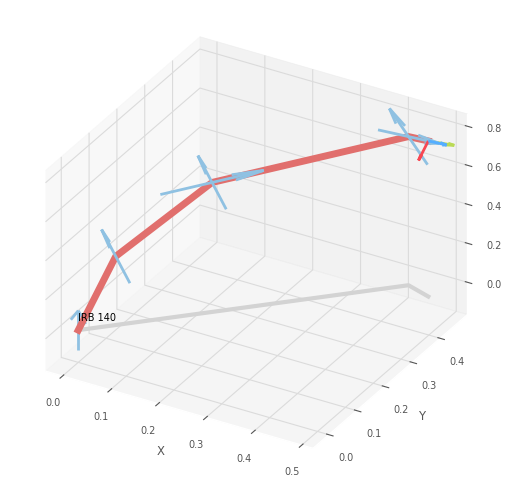

<Figure size 640x480 with 0 Axes>

In [28]:
q_start = [pi/4, -pi/3, -pi/4, pi/3, -pi/3, pi/4]
robot.plot(q_start)
plt.show()

### 3. Solving the direct kinematics problem

In [29]:
T_start = robot.fkine(q_start)
print(T_start)

   0.128     0.5962    0.7926    0.4878    
  -0.805     0.5292   -0.2681    0.4189    
  -0.5792   -0.6038    0.5477    0.7977    
   0         0         0         1         



### 4. Building the manipulator's working area

Initialize variables

In [30]:
n = 20  # Number of points on each axis
i = 0  #    Counter
move = [np.linspace(robot.links[i].qlim[0], robot.links[i].qlim[1], n) for i in range(6)]  # write down the limits of movement for the first three links
pose = np.zeros([3,n**3])  # Create an empty array to write data to

Calculating the working area

In [31]:
# We go through each point by itiration
for q1 in move[0]:
    for q2 in move[1]:
        for q3 in move[2]:
            Tt = robot.fkine([q1,q2,q3,0,0,0])  # We solve the DK by changing only the first 3 generalized coordinates
            for j in range(3):
                pose[j][i] = Tt.t[j]  # Saving points
            i += 1

Building the work space

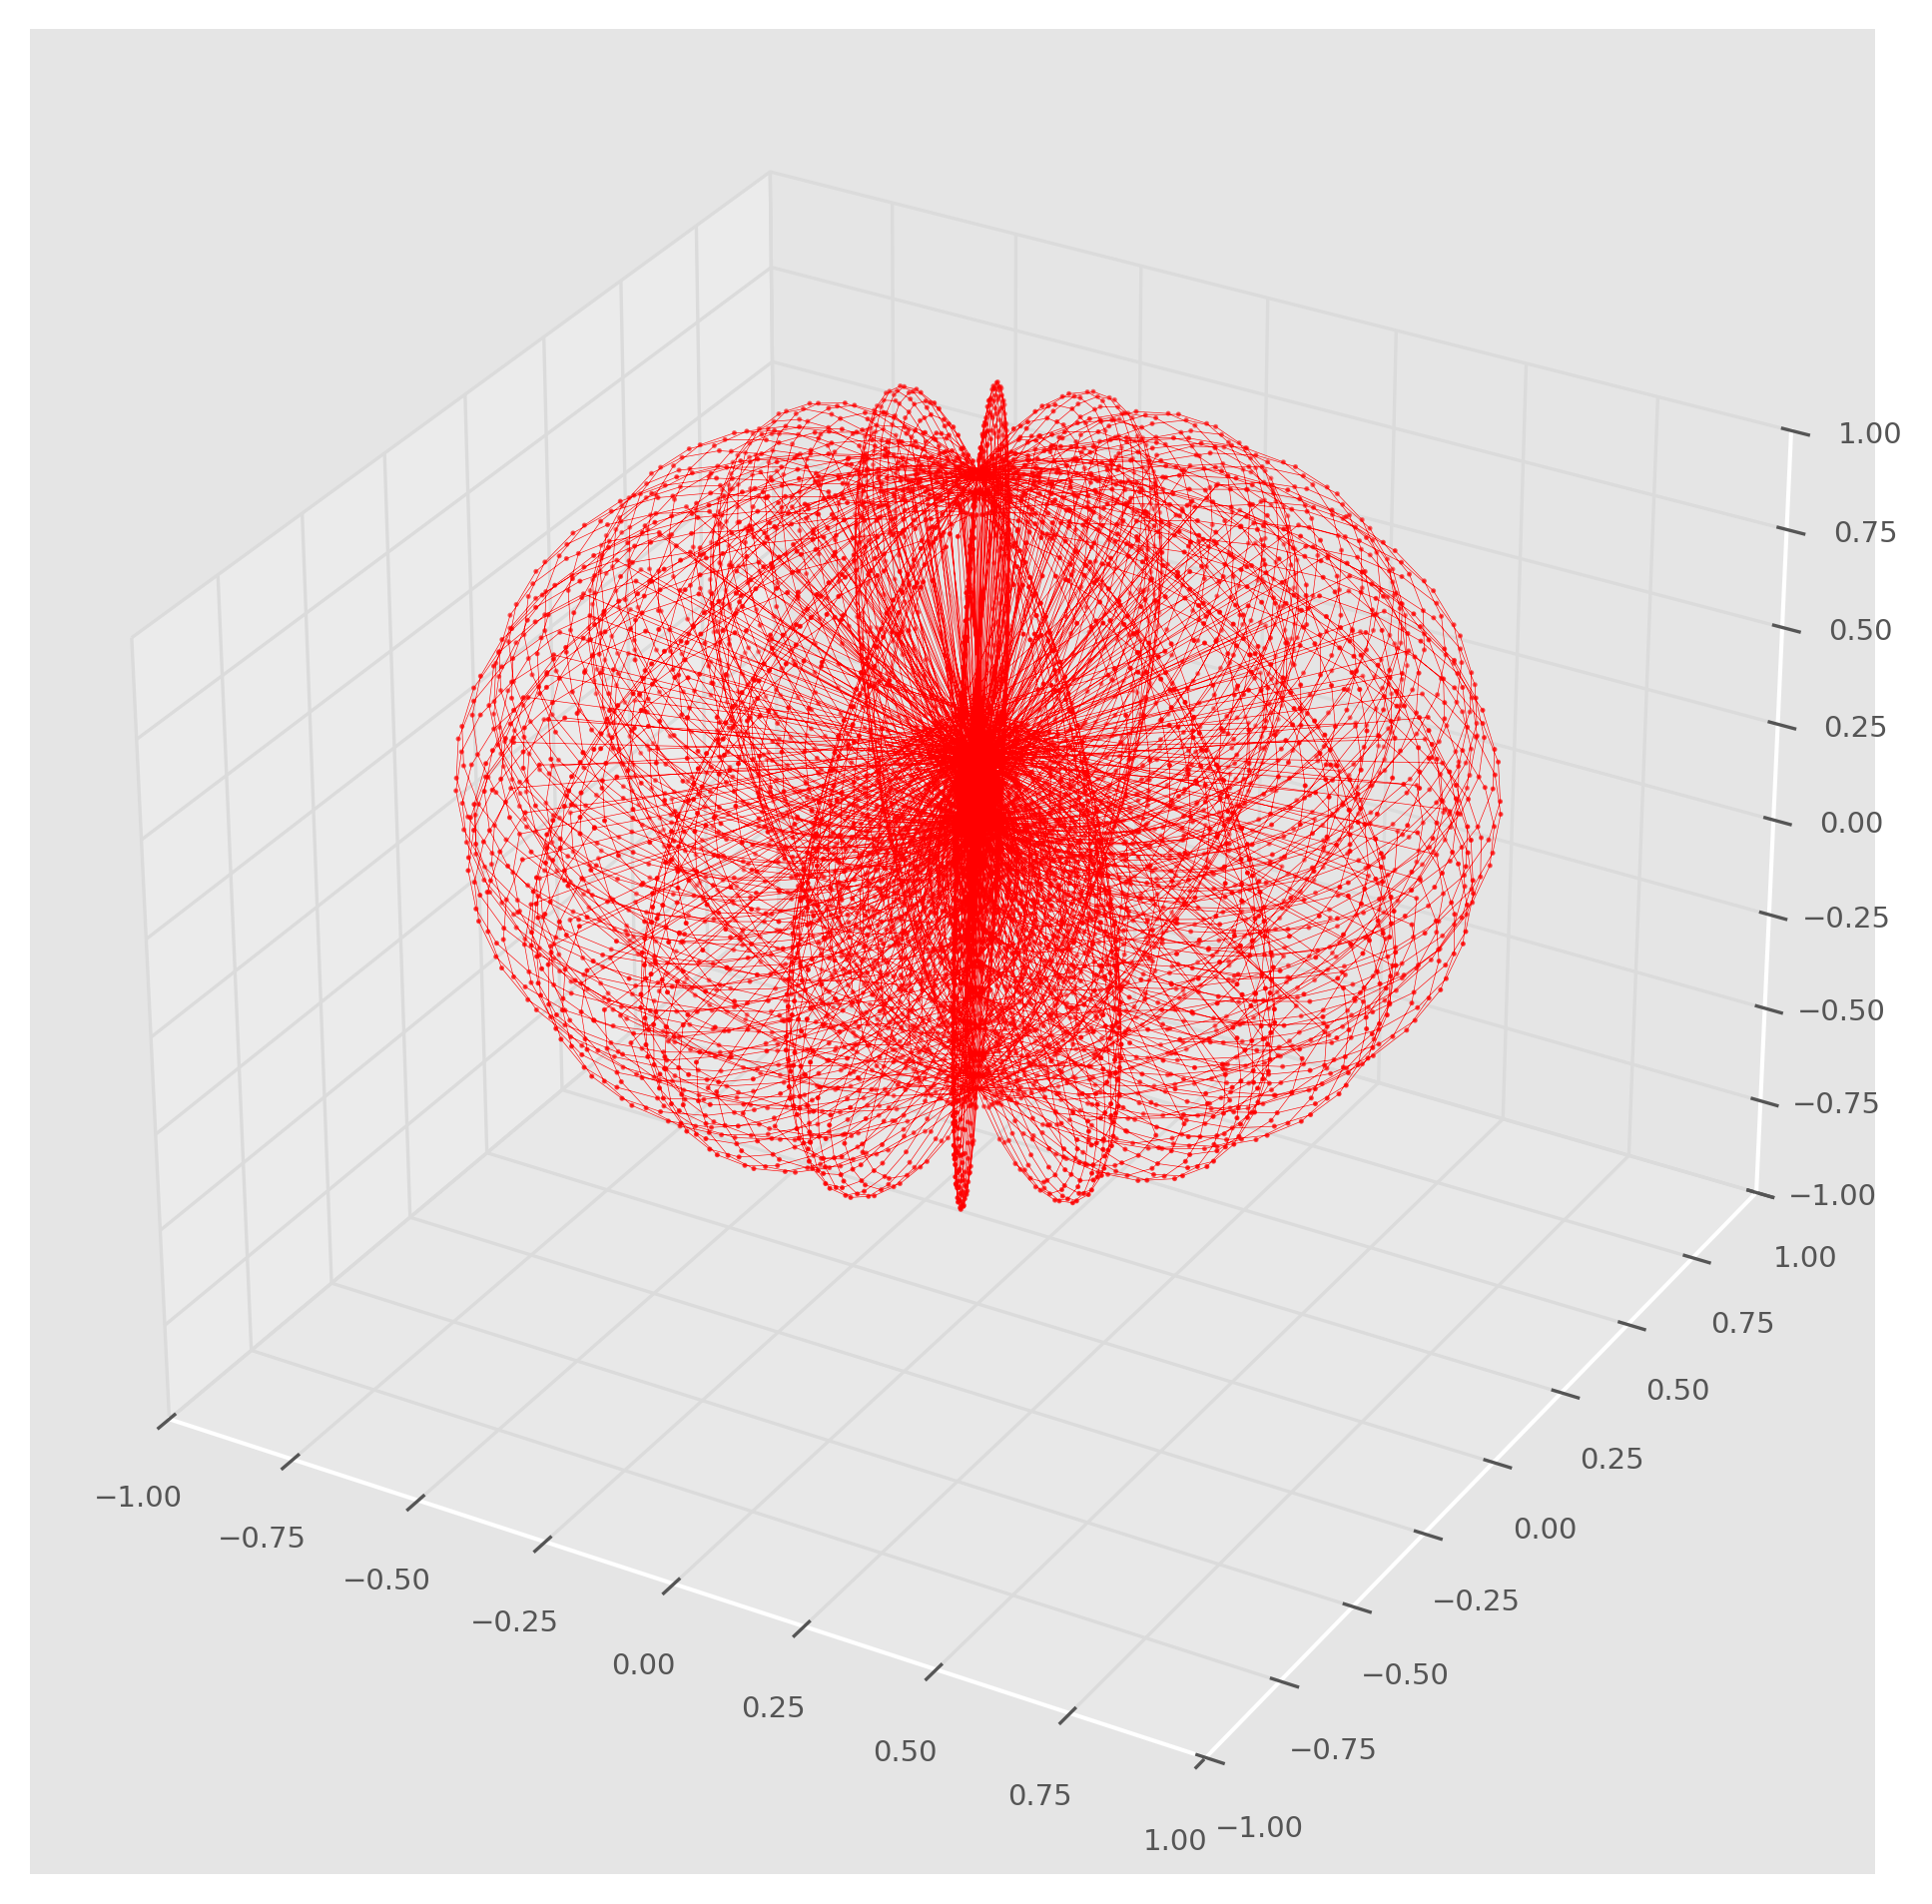

In [32]:
plt.figure(figsize=(8,8), dpi=300)
ax = plt.axes(projection="3d")
ax.plot3D(pose[0], pose[1], pose[2], color='red', linewidth=0.15)
ax.scatter3D(pose[0], pose[1], pose[2], s=0.5, color='red')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

### 5. Let's choose the end point and check it (let's solve the inverse kinematics problem)

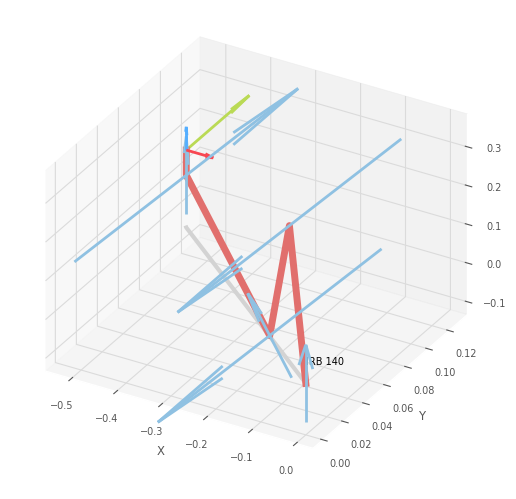

<Figure size 640x480 with 0 Axes>

In [33]:
point = [-0.5,0.1,0.2]
T_end = sb.transl(point)
q_end = robot.ikine_GN(T_end).q  # Есть другие методы, помимо ikine_GN
robot.plot(q_end)
plt.show()

### 6. Planning the trajectory

We consider 3 different methods to plan the trajectory:

- Trapezoidal (LSPB):
 creates time-optimal motions using three distinct phases: constant acceleration, steady velocity, then constant deceleration. Its trapezoidal velocity profile enables the fastest possible movement under acceleration constraints, but causes abrupt acceleration changes ("jerk") at phase transitions.

- Quintic (TPOLY):
 uses smooth fifth-order polynomial curves to generate continuous acceleration profiles. By minimizing jerk, it delivers exceptionally fluid motion ideal for vibration-sensitive applications, though this comes with slightly longer execution times compared to trapezoidal trajectories.

- JTRAJ:
 serves as the standard quintic-based trajectory in Robotics Toolboxes. It enforces zero start/end velocities/accelerations, striking a practical balance between motion smoothness and operational efficiency for general robotic tasks.

Let's plan a trajectory using the 'jtraj' method for $N$ = 100 points

In [34]:
N = 100
t_start = 0
t_stop = 5
t_shag = t_stop/N
time = np.arange(t_start, t_stop, t_shag)

tr_jtraj = rtb.jtraj(q_start, q_end, time)

Let's plan the same trajectory using the 'mtraj' method with the 'trapezoidal' function

In [35]:
tr_trap = rtb.mtraj(rtb.trapezoidal, q_start, q_end, time)

Let's plan the same trajectory using the 'mtraj' method with the 'quintic' function

In [36]:
tr_quin = rtb.mtraj(rtb.quintic, q_start, q_end, time)

### 7. Plotting graphs

Let's plot the position graphs for each link

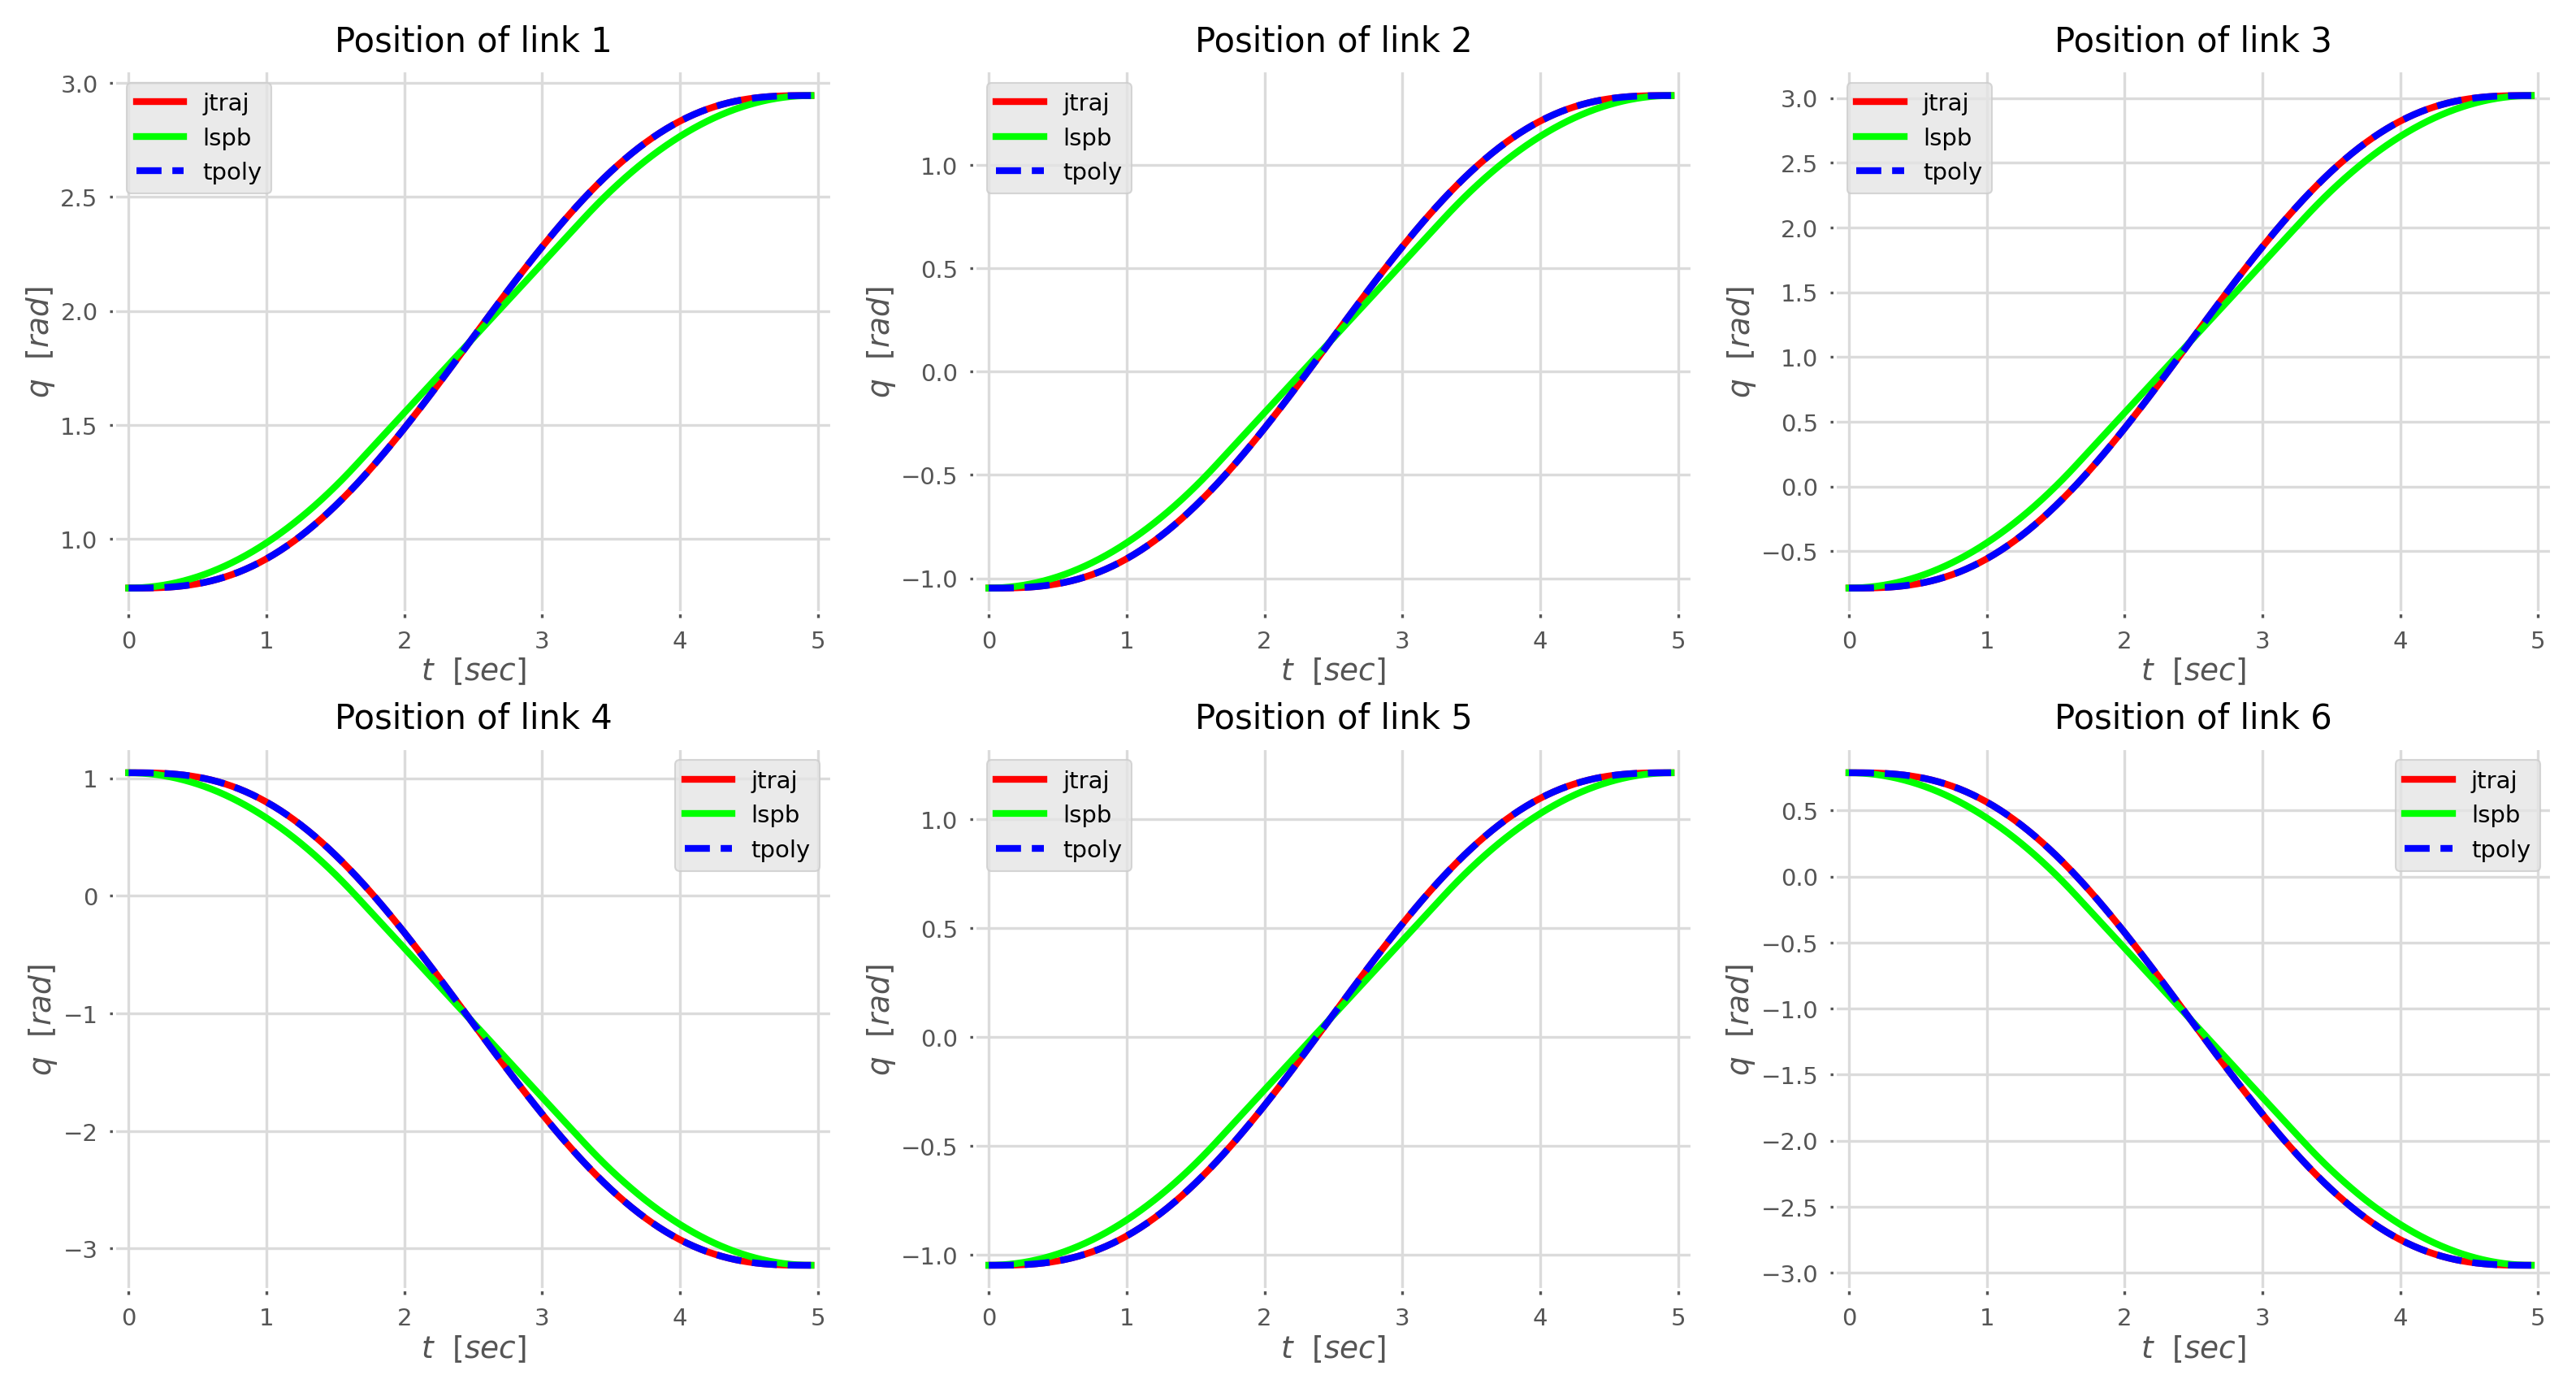

In [37]:
plt.figure(figsize=(10,5), dpi=300)  # Set canvas size and dot density (plot clarity)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.25)  # Set spacing between plots to prevent overlap
    traektoriya_jtraj = [tr_jtraj.q[i][g-1] for i in range(len(tr_jtraj.q))]  # Extract required data
    traektoriya_trap = [tr_trap.q[i][g-1] for i in range(len(tr_trap.q))]  # Extract required data
    traektoriya_quin = [tr_quin.q[i][g-1] for i in range(len(tr_quin.q))]  # Extract required data
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(1,0,0), label=r"jtraj")  # Draw line
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(0,1,0), label=r"lspb")  # Draw line
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(0,0,1), label=r"tpoly")  # Draw line
    plt.title(r"Position of link {}".format(g), fontsize=10)  # Plot title
    plt.ylabel(r"$q$  [$rad$]", fontsize=9)  # Y-axis label
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # X-axis label
    plt.grid(True)  # Add grid
    plt.legend()  # Display legend (shows content from 'label')
    ax = plt.gca()  # gca = get current axis - to edit specific figure
    ax.set_facecolor((1,1,1))  # Plot background color
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # X-axis limits
plt.show()

Let's plot the speed graphs for each link

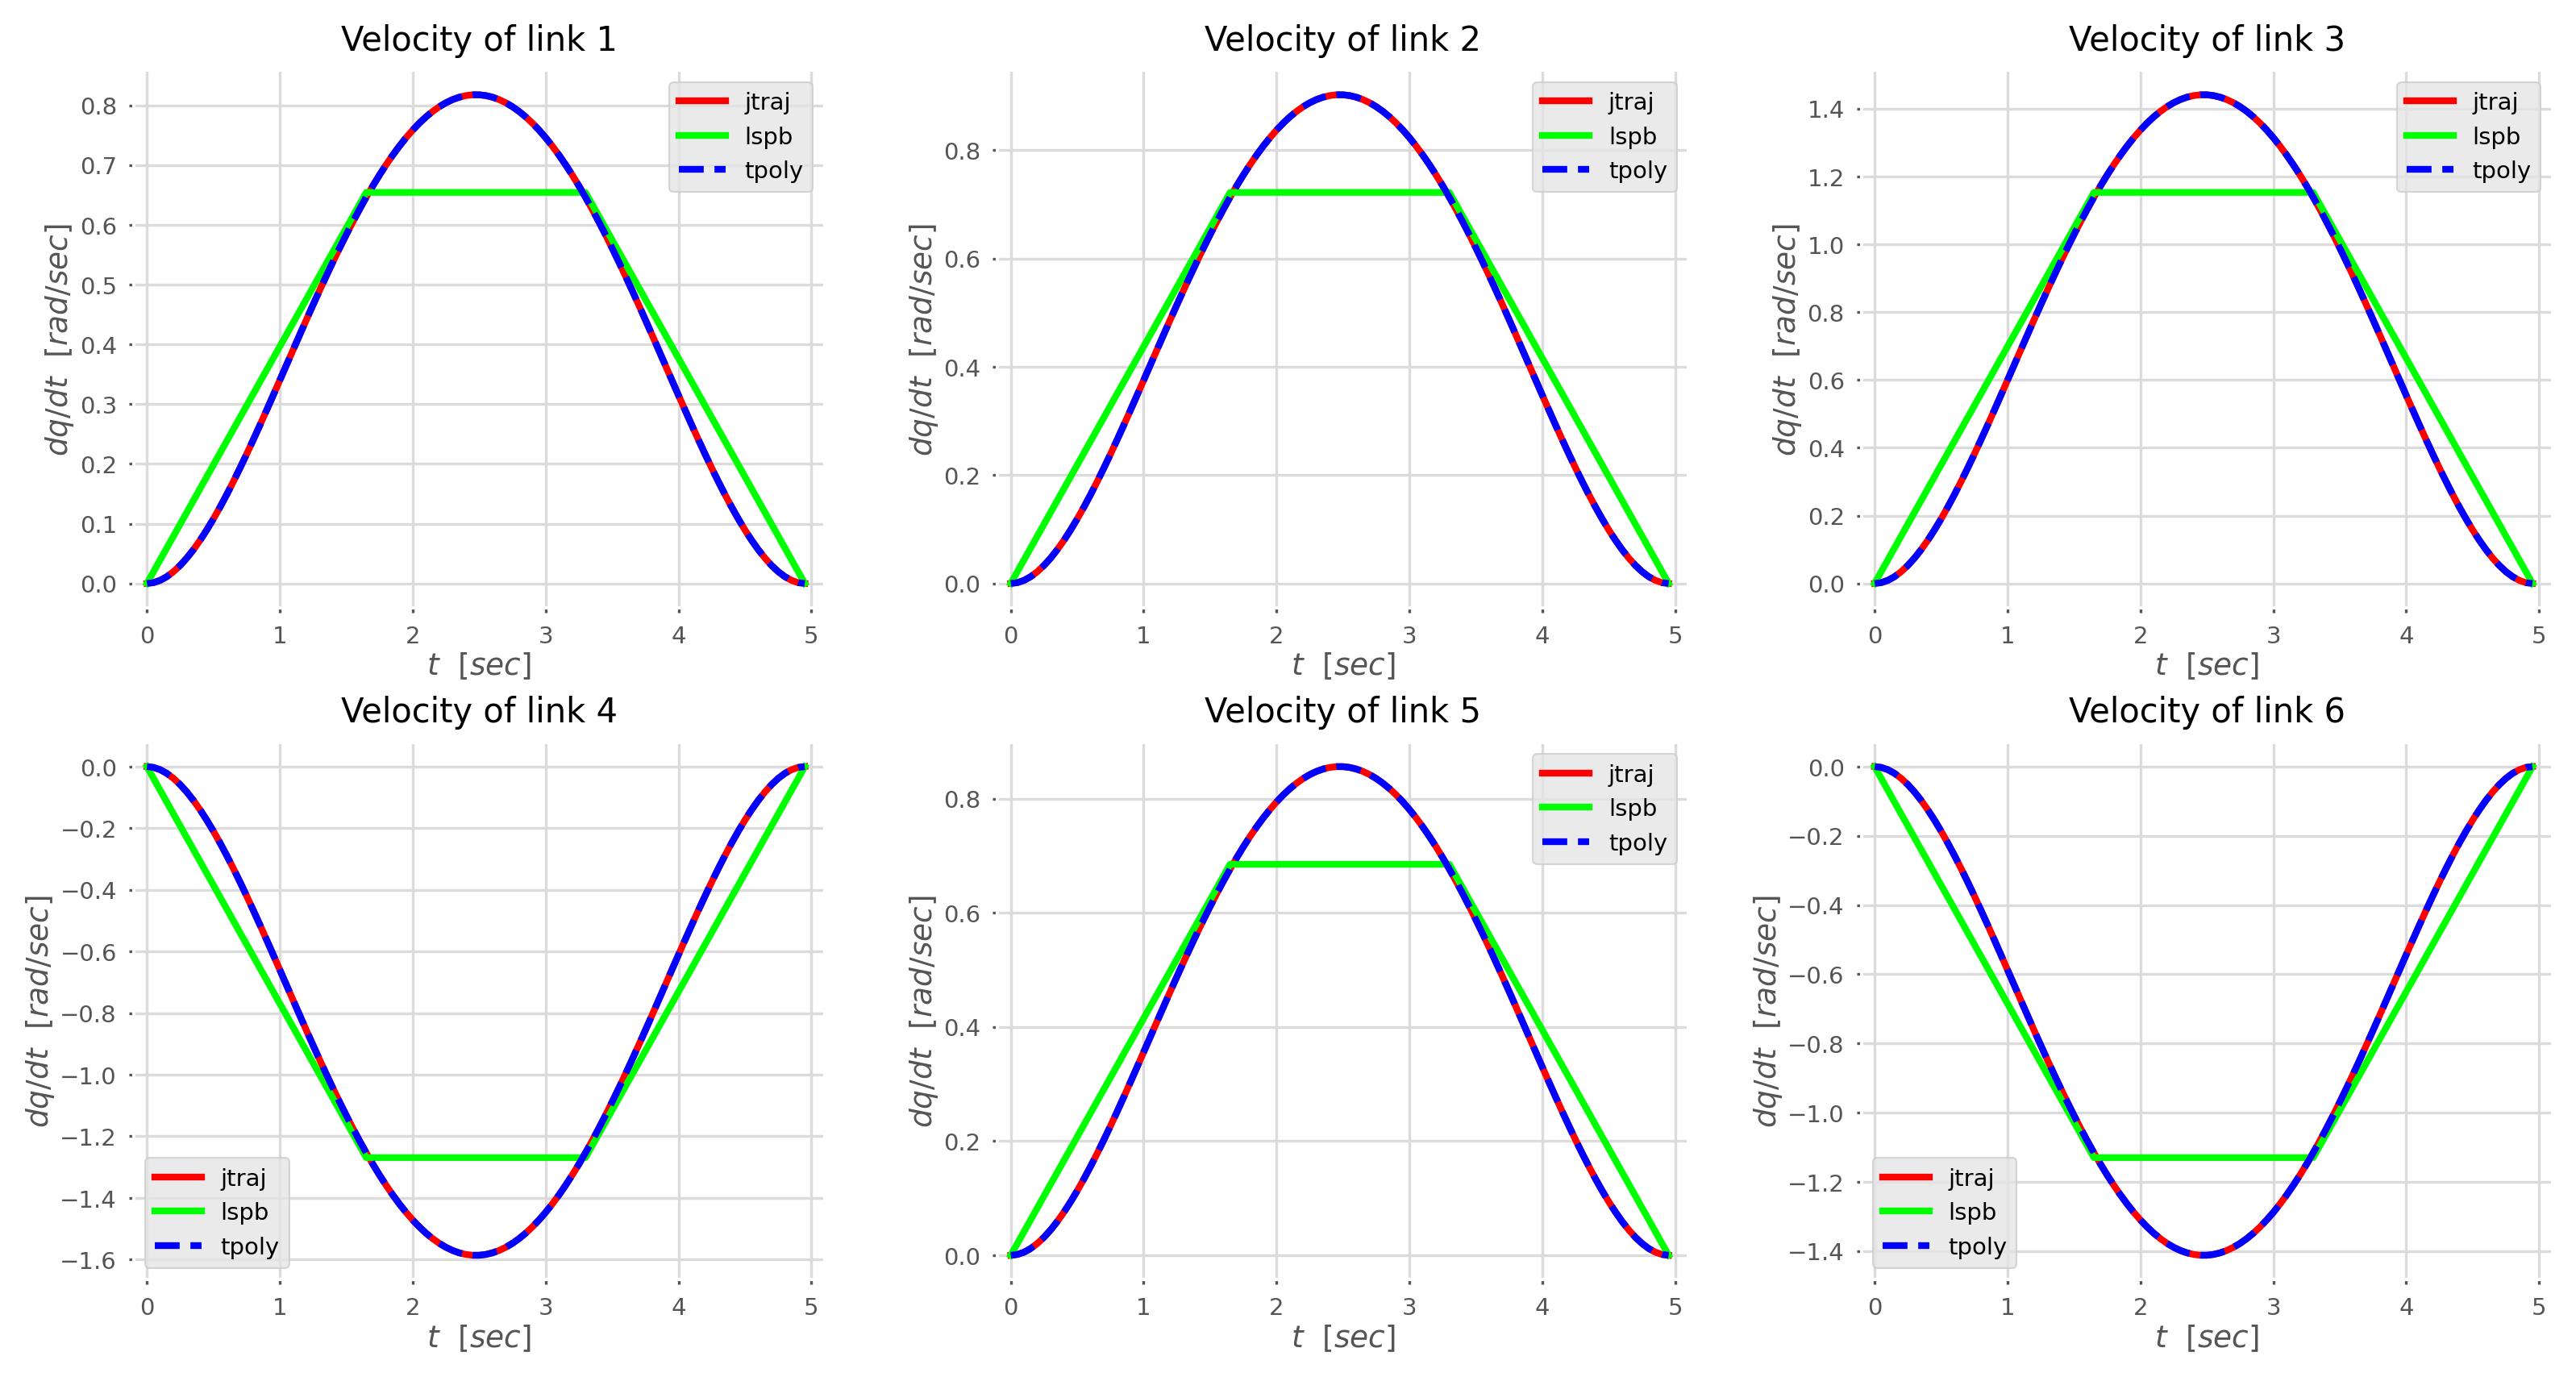

In [38]:
plt.figure(figsize=(10,5), dpi=300)  # Set canvas size and dot density (plot clarity)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.25)  # Set spacing between plots to prevent overlap
    traektoriya_jtraj = [tr_jtraj.qd[i][g-1] for i in range(len(tr_jtraj.qd))]  # Extract required data
    traektoriya_trap = [tr_trap.qd[i][g-1] for i in range(len(tr_trap.qd))]  # Extract required data
    traektoriya_quin = [tr_quin.qd[i][g-1] for i in range(len(tr_quin.qd))]  # Extract required data
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(1,0,0), label=r"jtraj")  # Draw line
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(0,1,0), label=r"lspb")  # Draw line
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(0,0,1), label=r"tpoly")  # Draw line
    plt.title(r"Velocity of link {}".format(g), fontsize=10)  # Plot title
    plt.ylabel(r"$dq/dt$  [$rad/sec$]", fontsize=9)  # Y-axis label
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # X-axis label
    plt.grid(True)  # Add grid
    plt.legend()  # Display legend (shows content from 'label')
    ax = plt.gca()  # gca = get current axis - to edit specific figure
    ax.set_facecolor((1,1,1))  # Plot background color
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # X-axis limits
plt.show()

Let's plot acceleration graphs for each link

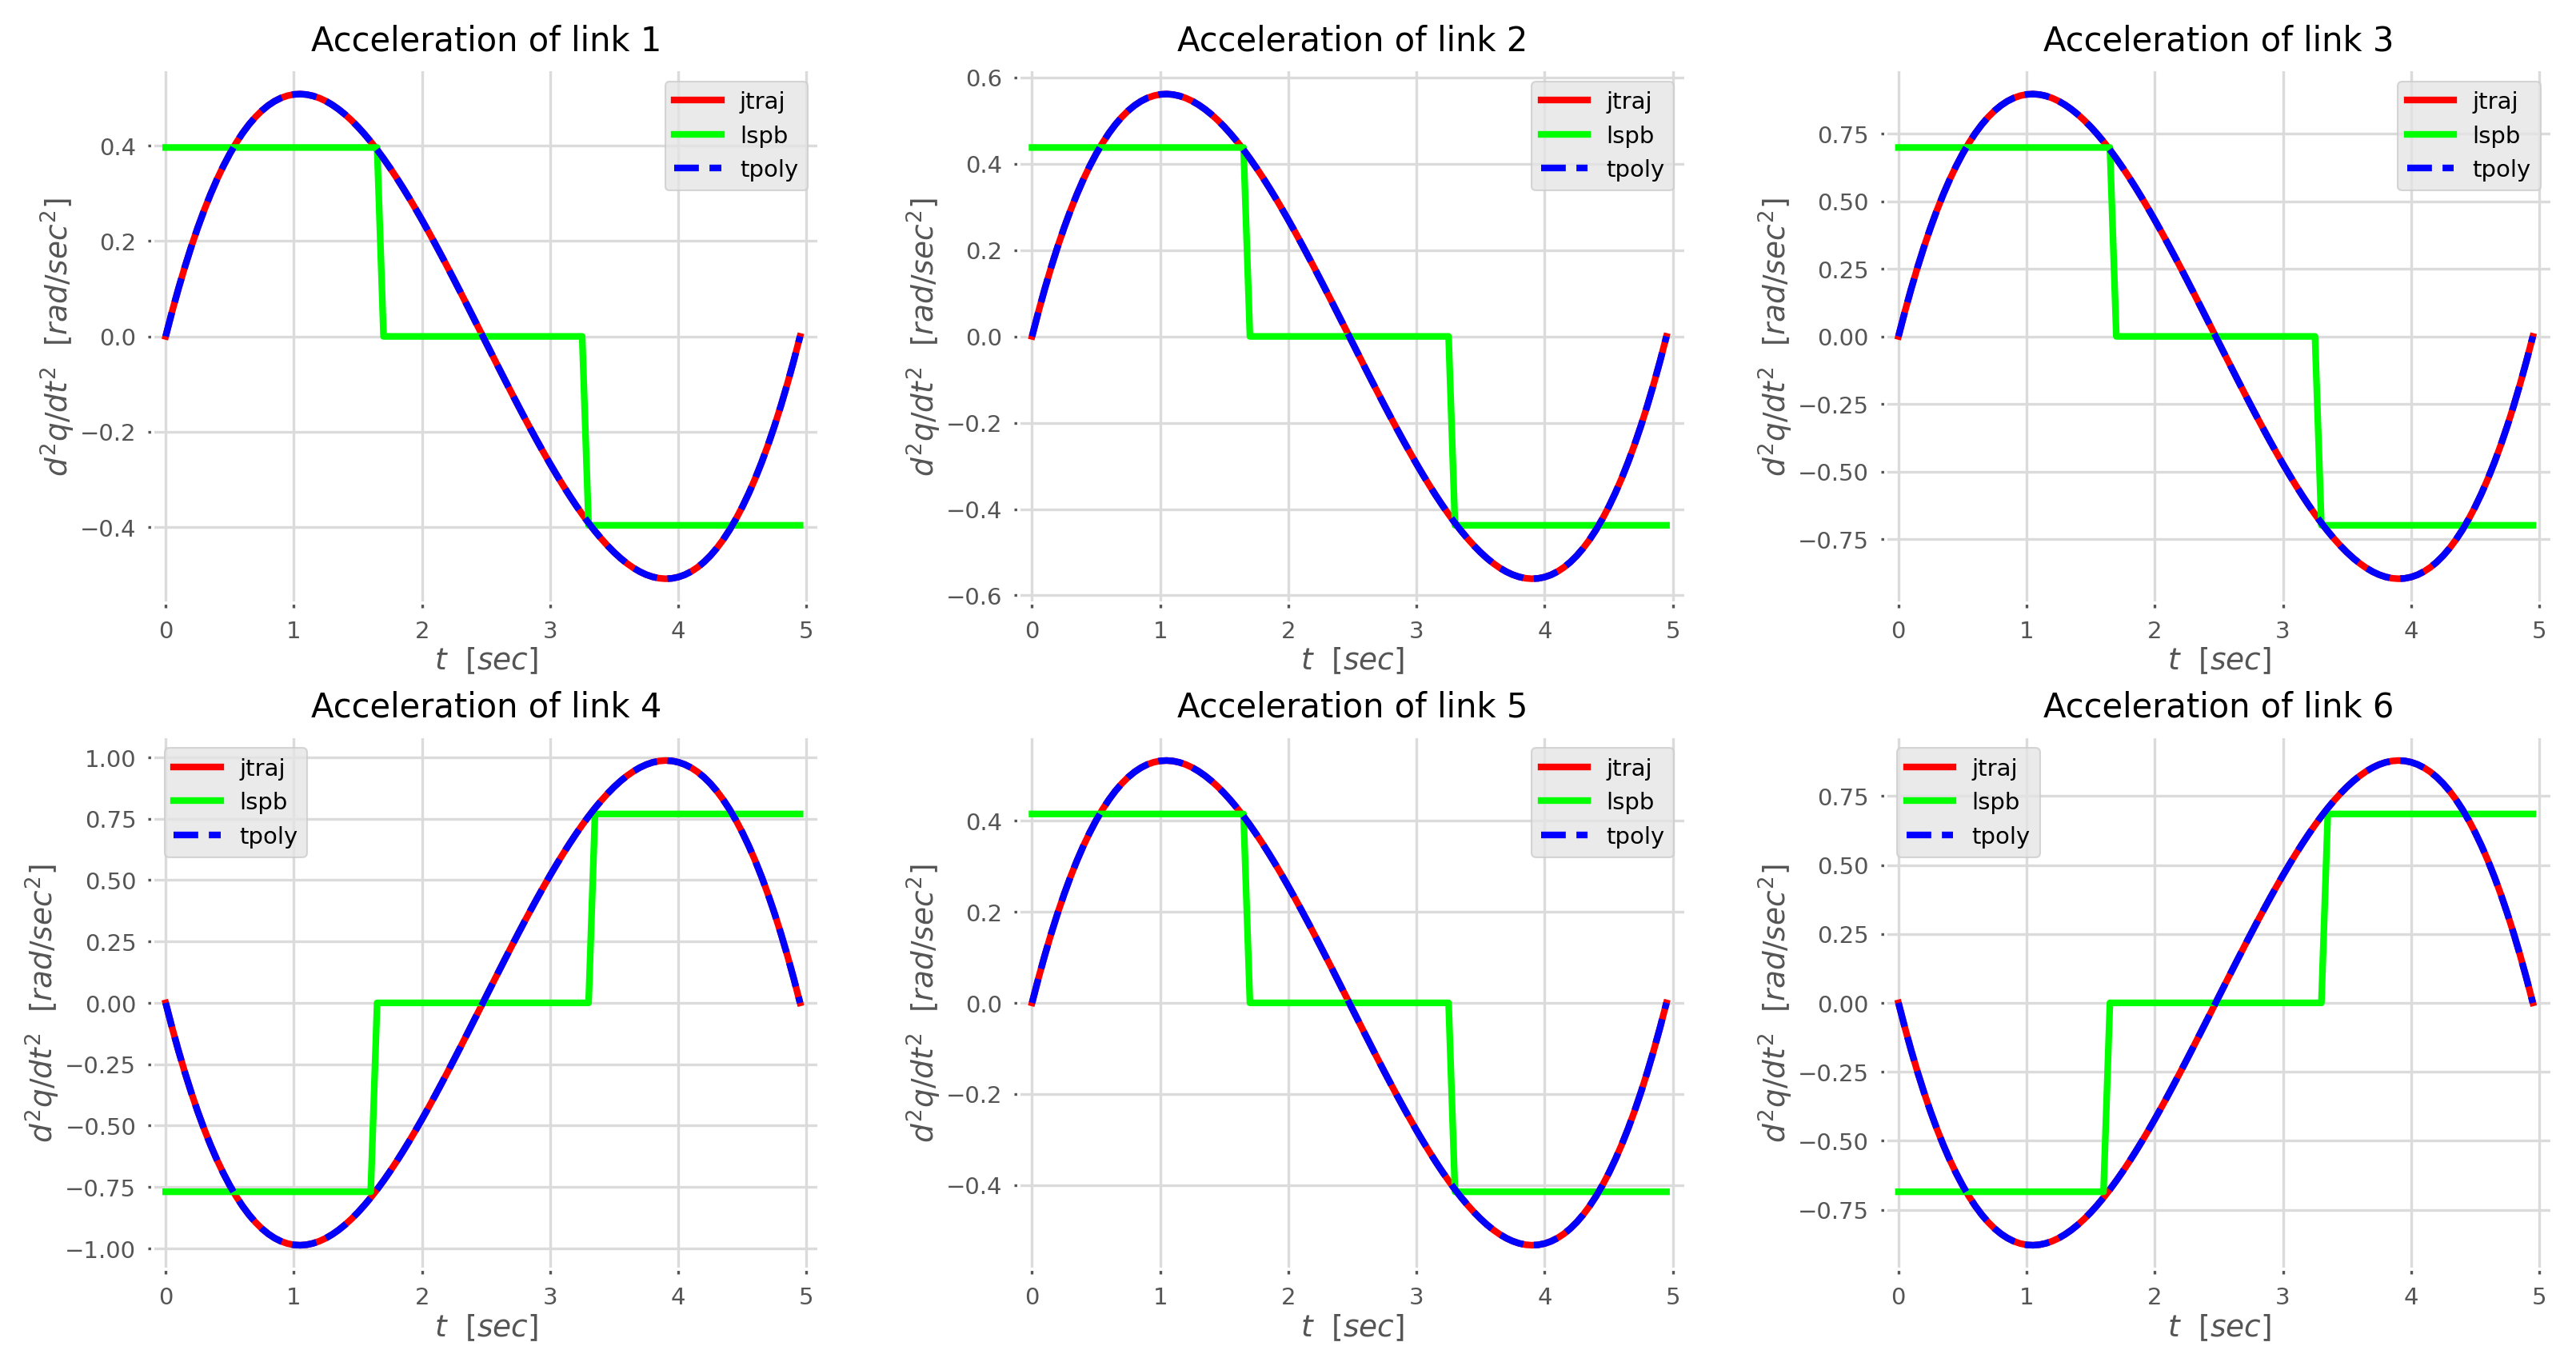

In [39]:
fig = plt.figure(figsize=(10,5), dpi=300)  # Set canvas size and dot density (plot clarity)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.25)  # Set spacing between plots to prevent overlap
    traektoriya_jtraj = [tr_jtraj.qdd[i][g-1] for i in range(len(tr_jtraj.qdd))]  # Extract required data
    traektoriya_trap = [tr_trap.qdd[i][g-1] for i in range(len(tr_trap.qdd))]  # Extract required data
    traektoriya_quin = [tr_quin.qdd[i][g-1] for i in range(len(tr_quin.qdd))]  # Extract required data
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(1,0,0), label=r"jtraj")  # Draw line
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(0,1,0), label=r"lspb")  # Draw line
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(0,0,1), label=r"tpoly")  # Draw line
    plt.title(r"Acceleration of link {}".format(g), fontsize=10)  # Plot title
    plt.ylabel(r"${d^2}q/d{t^2}$  [$rad/{sec}^2$]", fontsize=9)  # Y-axis label
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # X-axis label
    plt.grid(True)  # Add grid
    plt.legend()  # Display legend (shows content from 'label')
    ax = plt.gca()  # gca = get current axis - to edit specific figure
    ax.set_facecolor((1,1,1))  # Plot background color
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # X-axis limits
plt.show()

## Conclusion

We modeled the ABB IRB140 robot and visualized its workspace. Three trajectory methods were implemented and compared, and plots of position, speed, and acceleration of each link were constructed.

The plots visually contrast trajectory methods:


- JTRAJ and TPOLY delivers smoothest acceleration and velocity

- LSPB provides balanced performance with zero start/stop transients, Ideal method depends on application priorities: speed vs. smoothness.